Vimeo 90 k - slow motion and intermediate frames (SuperSloMoLite and FrameGAN generator)


In [ ]:
# Complete pipeline: SuperSloMoLite + FrameGAN on Vimeo-90K

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid


In [ ]:
# ========== DATASET ==========
class Vimeo90KDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.triplet_paths = self._get_triplets()

    def _get_triplets(self):
      triplets = []
      trainlist_path = os.path.join(self.root_dir, "..", "sep_trainlist.txt")
      trainlist_path = os.path.abspath(trainlist_path)

      with open(trainlist_path, 'r') as f:
        lines = f.read().splitlines()

      for line in lines:
        seq_path = os.path.join(self.root_dir, line)
        imgs = sorted(glob(os.path.join(seq_path, '*.png')))
        if len(imgs) >= 3:
            triplets.append(imgs[:3])  # Take first 3 frames
      return triplets



    def __len__(self):
        return len(self.triplet_paths)

    def __getitem__(self, idx):
        paths = self.triplet_paths[idx]
        imgs = [Image.open(p).convert("RGB") for p in paths]
        if self.transform:
            imgs = [self.transform(img) for img in imgs]
        return imgs[0], imgs[1], imgs[2]  # I0, I1, I2

In [ ]:
# ========== TRANSFORMS ==========
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])


In [ ]:
# ========== VISUALIZATION ==========
def show_sample_images(dataset, n=4):
    fig, axs = plt.subplots(n, 3, figsize=(9, n*3))
    for i in range(n):
        i0, i1, i2 = dataset[i]
        for j, img in enumerate([i0, i1, i2]):
            axs[i, j].imshow(np.transpose(img.numpy(), (1, 2, 0)))
            axs[i, j].axis('off')
    plt.suptitle("Sample Triplets (I0, I1, I2)")
    plt.tight_layout()
    plt.show()


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wangsally/vimeo-90k-9")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vimeo-90k-9


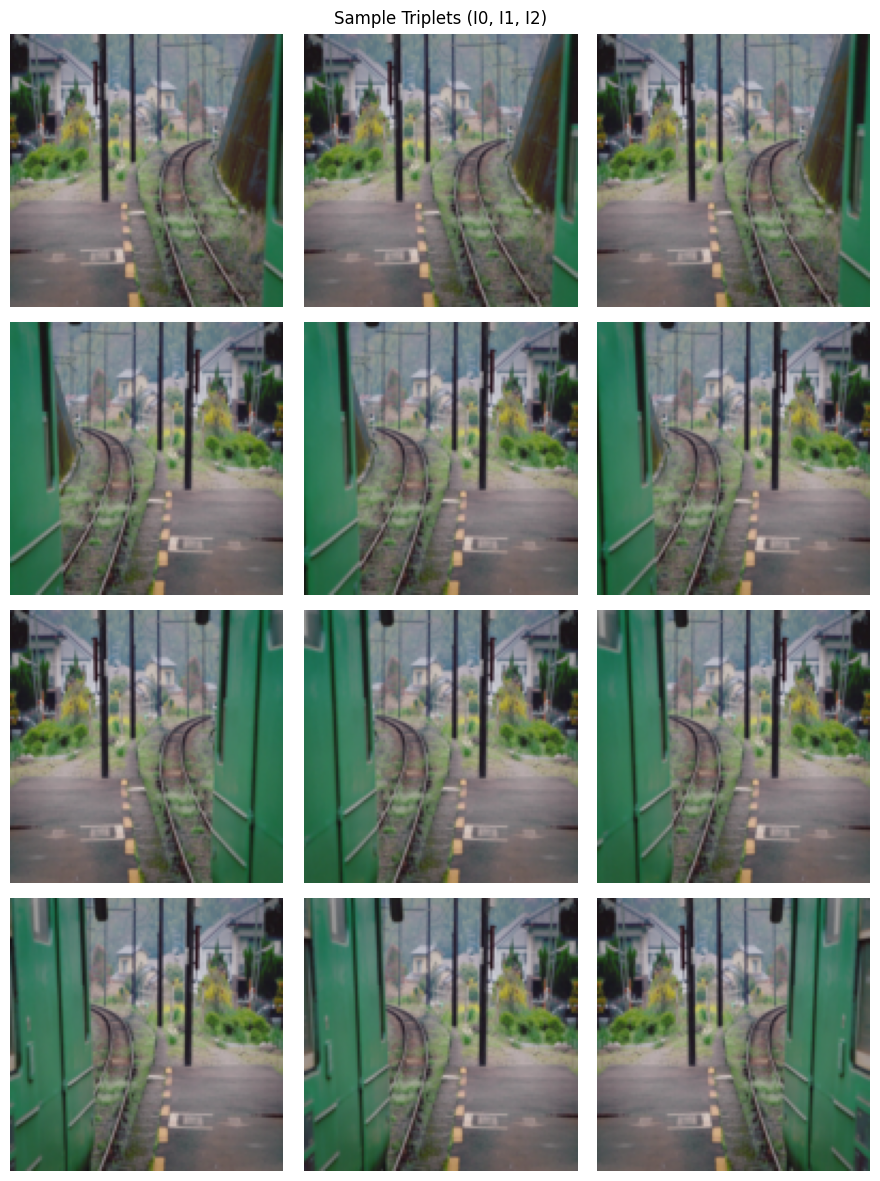

In [ ]:
# ========== DATALOADER ==========
root_path = "/kaggle/input/vimeo-90k-9/sequence"
dataset = Vimeo90KDataset(root_dir=root_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

show_sample_images(dataset)


In [ ]:
# ========== SUPER SLOMO LITE ==========
class SuperSloMoLite(nn.Module):
    def __init__(self):
        super(SuperSloMoLite, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, I0, I2):
        x = torch.cat([I0, I2], dim=1)
        x = self.encoder(x)
        I1_pred = self.decoder(x)
        return I1_pred


In [ ]:

# ========== FRAMEGAN GENERATOR ==========
class FrameGAN_Generator(nn.Module):
    def __init__(self):
        super(FrameGAN_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, I0, I2):
        x = torch.cat([I0, I2], dim=1)
        return self.model(x)

In [ ]:
# ========== TRAINING FUNCTION ==========
def train(model, dataloader, epochs=5, lr=1e-3, name="Model"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for I0, I1, I2 in tqdm(dataloader):
            I0, I1, I2 = I0.to(device), I1.to(device), I2.to(device)
            I1_pred = model(I0, I2)
            loss = criterion(I1_pred, I1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"[{name}] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    return losses



In [ ]:
# ========== TRAIN BOTH MODELS ==========
slomo_model = SuperSloMoLite()
gan_model = FrameGAN_Generator()

slomo_losses = train(slomo_model, dataloader, epochs=10, name="SuperSloMoLite")
gan_losses = train(gan_model, dataloader, epochs=10, name="FrameGAN_Generator")



100%|██████████| 773/773 [02:53<00:00,  4.44it/s]


[SuperSloMoLite] Epoch 1/10 - Loss: 0.0280


100%|██████████| 773/773 [02:05<00:00,  6.14it/s]


[SuperSloMoLite] Epoch 2/10 - Loss: 0.0255


100%|██████████| 773/773 [02:05<00:00,  6.18it/s]


[SuperSloMoLite] Epoch 3/10 - Loss: 0.0250


100%|██████████| 773/773 [02:04<00:00,  6.20it/s]


[SuperSloMoLite] Epoch 4/10 - Loss: 0.0256


100%|██████████| 773/773 [02:06<00:00,  6.13it/s]


[SuperSloMoLite] Epoch 5/10 - Loss: 0.0255


100%|██████████| 773/773 [02:04<00:00,  6.23it/s]


[SuperSloMoLite] Epoch 6/10 - Loss: 0.0253


100%|██████████| 773/773 [02:06<00:00,  6.12it/s]


[SuperSloMoLite] Epoch 7/10 - Loss: 0.0253


100%|██████████| 773/773 [02:05<00:00,  6.15it/s]


[SuperSloMoLite] Epoch 8/10 - Loss: 0.0250


100%|██████████| 773/773 [02:04<00:00,  6.21it/s]


[SuperSloMoLite] Epoch 9/10 - Loss: 0.0248


100%|██████████| 773/773 [02:04<00:00,  6.20it/s]


[SuperSloMoLite] Epoch 10/10 - Loss: 0.0248


100%|██████████| 773/773 [02:27<00:00,  5.23it/s]


[FrameGAN_Generator] Epoch 1/10 - Loss: 0.0338


100%|██████████| 773/773 [02:27<00:00,  5.24it/s]


[FrameGAN_Generator] Epoch 2/10 - Loss: 0.0307


100%|██████████| 773/773 [02:28<00:00,  5.21it/s]


[FrameGAN_Generator] Epoch 3/10 - Loss: 0.0301


100%|██████████| 773/773 [02:27<00:00,  5.24it/s]


[FrameGAN_Generator] Epoch 4/10 - Loss: 0.0289


100%|██████████| 773/773 [02:27<00:00,  5.24it/s]


[FrameGAN_Generator] Epoch 5/10 - Loss: 0.0275


100%|██████████| 773/773 [02:27<00:00,  5.24it/s]


[FrameGAN_Generator] Epoch 6/10 - Loss: 0.0278


100%|██████████| 773/773 [02:27<00:00,  5.24it/s]


[FrameGAN_Generator] Epoch 7/10 - Loss: 0.0276


100%|██████████| 773/773 [02:27<00:00,  5.26it/s]


[FrameGAN_Generator] Epoch 8/10 - Loss: 0.0268


100%|██████████| 773/773 [02:26<00:00,  5.26it/s]


[FrameGAN_Generator] Epoch 9/10 - Loss: 0.0269


100%|██████████| 773/773 [02:31<00:00,  5.09it/s]

[FrameGAN_Generator] Epoch 10/10 - Loss: 0.0264


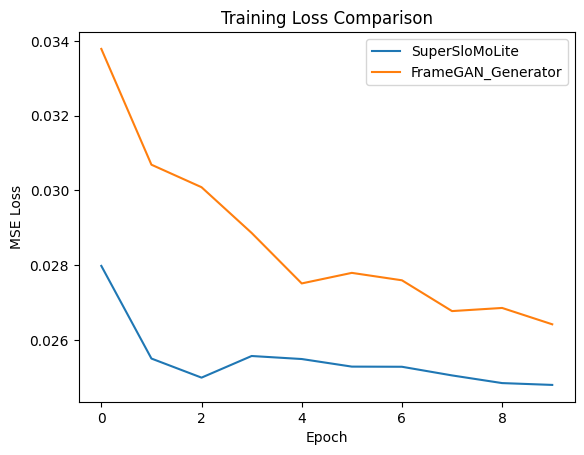

In [ ]:
# ========== PLOT TRAINING LOSSES ==========
plt.plot(slomo_losses, label="SuperSloMoLite")
plt.plot(gan_losses, label="FrameGAN_Generator")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()



In [ ]:
# ========== SAVE MODELS ==========
torch.save(slomo_model.state_dict(), "superslomo_vimeo90k.pth")
torch.save(gan_model.state_dict(), "framegan_vimeo90k.pth")

from google.colab import files
files.download("superslomo_vimeo90k.pth")
files.download("framegan_vimeo90k.pth")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ========== INTERPOLATE WITH CONTROL ==========
def interpolate_multiple_frames(model, I0, I2, num_frames=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    I0, I2 = I0.unsqueeze(0).to(device), I2.unsqueeze(0).to(device)
    model.to(device)
    model.eval()

    frames = []
    for t in np.linspace(0, 1, num_frames + 2)[1:-1]:
        with torch.no_grad():
            I1_pred = model(I0, I2)
            interpolated = t * I1_pred + (1 - t) * (I0 + I2) / 2
            frames.append(interpolated.squeeze(0).cpu())
    return frames


In [ ]:
# ========== VIDEO PROCESSING SUPPORT ==========
def extract_frames_from_video(video_path, transform=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if transform:
            img = transform(img)
        frames.append(img)
    cap.release()
    return frames



In [ ]:
# Example usage:
# I0, _, I2 = dataset[0]
# frames = interpolate_multiple_frames(slomo_model, I0, I2, num_frames=5)
# for i, f in enumerate(frames):
#     plt.imshow(np.transpose(f.numpy(), (1, 2, 0)))
#     plt.title(f"Intermediate Frame {i+1}")
#     plt.axis('off')
#     plt.show()

# Example video usage:
# video_frames = extract_frames_from_video("example.mp4", transform=transform)
# I0, I2 = video_frames[0], video_frames[-1]
# frames = interpolate_multiple_frames(slomo_model, I0, I2, num_frames=5)
# for f in frames: ...
